In [2]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from os import system
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import SVG
from IPython.display import display 
from IPython.display import HTML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [37]:
sns.set(rc={'figure.figsize': (9,6)})


events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [38]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [39]:
events_data['date'] = pd.to_datetime(events_data.timestamp , unit = 's')


events_data.head()


events_data['day'] = events_data.date.dt.date


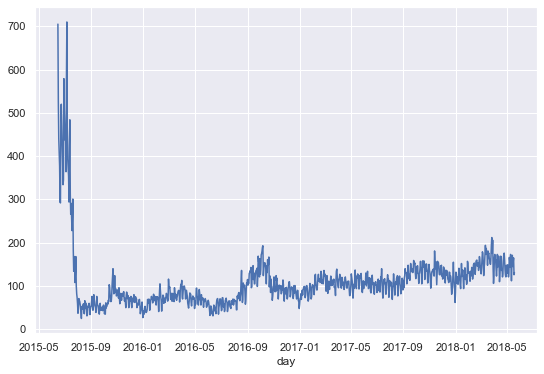

In [40]:
events_data.groupby('day').user_id.nunique().plot()

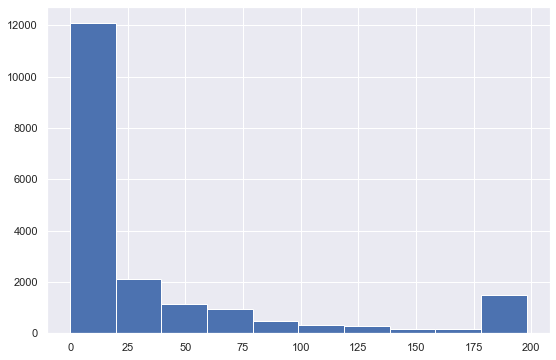

In [41]:
events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index().discovered.hist()


users_events_data = events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()

In [42]:

users_events_data.head()


#ТЕПЕРЬ ПЕРЕХОДИМ К 2-МУ ДАТАФРЕЙМУ SUBMISSIONS DATA И НАЧИНАЕМ ОБРАБОТКУ ДАННЫХ

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp , unit = 's')
submissions_data['day'] = submissions_data.date.dt.date


users_scores=submissions_data.pivot_table(index='user_id' , 
                        columns='submission_status' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()

In [43]:
users_scores.head()


gaps_data=events_data[['user_id' , 'day' , 'timestamp']].drop_duplicates(subset=[ 'day' ])    .groupby('user_id')['timestamp'].apply(list)     .apply(np.diff).values




gaps_data=pd.Series(np.concatenate(gaps_data , axis=0))




gaps_data = gaps_data / (24*60*60)   #делим на (20*60*60) что би из таймстемпов подучить значения в днях


gaps_data.quantile(0.90) 

15.203456018518565

In [44]:
users_data = events_data.groupby('user_id' , as_index=False)    .aggregate({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})


now = 1526772811
drop_out_treshold = 2592000


In [45]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold


users_data = users_data.merge(users_scores , how='outer')


users_data = users_data.fillna(0)

In [46]:
users_data = users_data.merge(users_events_data , how='outer')


users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()


users_data  =  users_data.merge(users_days , how='outer')

users_data['passed_course'] = users_data.passed > 170

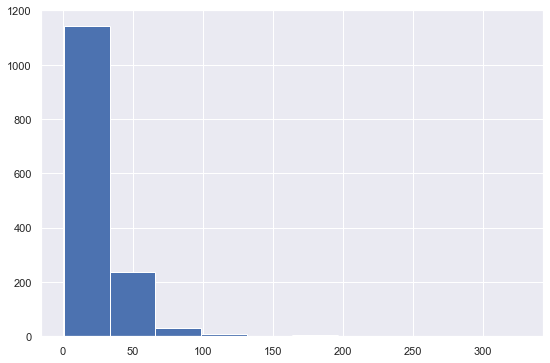

In [47]:
users_data.groupby('passed_course').count()


100 *  1425 / 17809   # процент закончивших курс 


users_data.head()     # почти финальная часть обработки данных 


users_data[users_data.passed_course].day.hist()

In [48]:
user_min_time = events_data.groupby('user_id' , as_index=False).agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'} , axis=1)


users_data = users_data.merge(user_min_time , how='outer')

events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)


learning_time_treshhold =  3 * 24 *60 * 60  

In [49]:
user_learning_time_treshhold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshhold).map(str)


user_min_time['user_learning_time_treshhold'] = user_learning_time_treshhold

In [50]:
user_learning_time_treshhold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [51]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [52]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [53]:
submissions_data.groupby(['step_id','submission_status'])\
    .agg({'date' : 'count'})\
    .query('submission_status == "wrong"')\
    .sort_values('date')

,,date
step_id,submission_status,
32929,wrong,85
32175,wrong,342
33362,wrong,673
33681,wrong,703
33482,wrong,707
...,...,...
32075,wrong,10003
33481,wrong,10300
32202,wrong,13002


In [54]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [55]:
user_min_time.head()

,user_id,min_timestamp,user_learning_time_treshhold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [56]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshhold']])

In [57]:
events_data.shape

(3480703, 8)

In [58]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshhold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [59]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshhold]

In [60]:
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshhold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [61]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [62]:
submissions_data


,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


KeyError: "['user_learning_time_treshold'] not in index"

In [65]:
user_min_time

,user_id,min_timestamp,user_learning_time_treshhold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860
...,...,...,...
19229,26790,1451484016,26790_1451743216
19230,26793,1510225031,26793_1510484231
19231,26794,1495287049,26794_1495546249
19232,26797,1508425316,26797_1508684516


In [64]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day,user_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,2615_1501946959
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,13177_1503059927
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,15253_1506348153
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1424_1523035316


In [66]:
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshhold']])

In [69]:
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshhold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [68]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshhold
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149,15853_1434605177
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164,15853_1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,2615_1501946959,2615_1502205860
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,13177_1503059927,13177_1503314487
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,15253_1506348153,15253_1506606463
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1424_1523035316,1424_1523294469


In [85]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename({'day' : 'days'}, axis = 1)

In [86]:
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [87]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename({'step_id' : 'steps_tried'}, axis = 1)

In [88]:
steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


In [89]:
X = X.merge(steps_tried)

In [90]:
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [91]:
X = X.merge(submissions_data_train.pivot_table(index='user_id' , 
                        columns='submission_status' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index())

In [92]:
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [95]:
X['correct_ratio'] = round(X.correct / (X.correct + X.wrong), 2)

In [96]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.00
8909,26790,1,1,1,0,1.00
8910,26794,3,27,31,9,0.78
8911,26797,1,2,2,0,1.00


In [97]:
X = X.merge(events_data.pivot_table(index='user_id' , 
                        columns='action' , 
                        values = 'step_id' , 
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()[['user_id', 'viewed']], how = 'outer')

In [98]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,10
1,3,1.0,4.0,4.0,4.0,0.50,192
2,8,1.0,11.0,9.0,21.0,0.30,156
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,698
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


In [100]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [99]:
X = X.fillna(0)

In [101]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']])

In [102]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [103]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,10,False,True
1,3,1.0,4.0,4.0,4.0,0.50,192,False,True
2,8,1.0,11.0,9.0,21.0,0.30,156,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,698,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [118]:
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64

In [117]:
y = y.map(int)

In [111]:
X = X.drop(['passed_course', 'is_gone_user'], axis = 1)

KeyError: "['passed_course' 'is_gone_user'] not found in axis"

In [108]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,10
1,3,1.0,4.0,4.0,4.0,0.50,192
2,8,1.0,11.0,9.0,21.0,0.30,156
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,698
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [109]:
X = X.set_index(X.user_id)

In [110]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.00,10
3,3,1.0,4.0,4.0,4.0,0.50,192
8,8,1.0,11.0,9.0,21.0,0.30,156
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...,...
26774,26774,0.0,0.0,0.0,0.0,0.00,1
26781,26781,0.0,0.0,0.0,0.0,0.00,698
26788,26788,0.0,0.0,0.0,0.0,0.00,1


In [112]:
X = X.drop(['user_id'], axis = 1)

In [113]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,10
3,1.0,4.0,4.0,4.0,0.50,192
8,1.0,11.0,9.0,21.0,0.30,156
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,651
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,698
26788,0.0,0.0,0.0,0.0,0.00,1


In [119]:
X.to_csv('X_data.csv')
y.to_csv('Y_data.csv')